## Autoencoders

In this part of the tutorial, we learn how to autoencode images from the MNIST dataset. We then show how we can use autoencoded representations of these images as features for classification with logistic regression (as opposed to using raw pixels as features). 

Steps: 

1a. Load the MNIST dataset (train and test), we will not use the labels in this part of the tutorial
1b. Create the noisy version of the dataset by injecting noise into MNIST images

2a. Train (using Keras) the simple autoencoder with clean input 
2b. Train (using Keras) the denoising autoencoder with noisy input

3a. Train and evaluate the logistic regression classifier using raw input features (pixels)
3b. Train and evaluate the logistic regression classifier using latent representations of images obtained with the clean autoencoder
3c. Train and evaluate the logistic regression classifier using latent representations of images obtained with the denoising autoencoder 



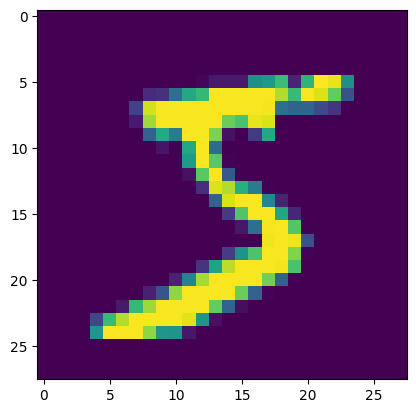

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the MNIST data
(X_autoenc, _), (X_classification, y_classification) = mnist.load_data() 

X_autoenc = X_autoenc.astype('float32') / 255.
X_classification = X_classification.astype('float32') / 255.

plt.imshow(X_autoenc[0])

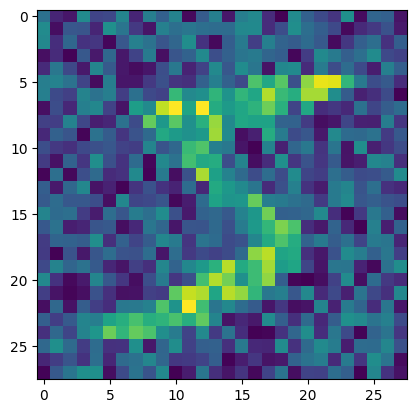

In [2]:
# Creating the noisy version of the MNIST data
noise = 1 * np.random.random(X_autoenc.shape)
X_autoenc_noisy = X_autoenc + noise

plt.imshow(X_autoenc_noisy[0])

Keras (https://keras.io/): a high-level DL Python framework. It abstracts away the details of implementation of DL models with readily available components and architectures. 

There are two main way of defining a model in Keras: 
(1) via chaining of invidual layers -- output of one is input to another
(2) by defining a whole model (from keras.models import Sequential) with all layers

We now first use (1). 

In [4]:
# defining an autoencoder

from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 64 # original dim is 784 (28*28) 
input_img = Input(shape=(784, ))

# defining the encoder network (just a single layer 784x32 FFDN)
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# ============================================================

# encoder, for obtaining encoded representations after training
encoder = Model(input_img, encoded)

# full autoencoder for training
autoencoder = Model(input_img, decoded)

Now that the model is defined, we can train it on some images (data points)

In [6]:
# training the autoencoder
autoencoder.compile(optimizer="adam", loss = "mean_squared_error")

# just converting 28x28 image matrices into 784 dimensional vectors
X_autoenc_input = X_autoenc.reshape((len(X_autoenc), np.prod(X_autoenc.shape[1:]))) 
X_autoenc_noisy_input = X_autoenc_noisy.reshape((len(X_autoenc_noisy), np.prod(X_autoenc_noisy.shape[1:])))

print(X_autoenc_input.shape)
print(X_autoenc_noisy_input.shape)

# creating dev set for cross-validation and early stopping
# first 5000 images will be used for the validation dataset, the rest as the training dataset
X_dev_input = X_autoenc_input[:5000]
X_train_input = X_autoenc_input[5000:]

X_dev_noisy_input = X_autoenc_noisy_input[:5000]
X_train_noisy_input = X_autoenc_noisy_input[5000:]


print(X_dev_input.shape)
print(X_train_input.shape)

#training the regular autoencoder
#autoencoder.fit(X_train_input, X_train_input,
#                epochs=200,
#                batch_size=256,
#                shuffle=True,
#                validation_data=(X_dev_input, X_dev_input))

# training the denoising autorencoder
autoencoder.fit(X_train_noisy_input, X_train_input,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_dev_noisy_input, X_dev_input))

(60000, 784)
(60000, 784)
(5000, 784)
(55000, 784)
Epoch 1/50
430/430 [==============================] - 5s 9ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 2/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 3/50
430/430 [==============================] - 4s 8ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 4/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 5/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 6/50
430/430 [==============================] - 3s 7ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 7/50
430/430 [==============================] - 4s 8ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 8/50
430/430 [==============================] - 4s 8ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 9/50
430/430 [==============================] - 4s 8ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 10/50
430/430 [============================

In [7]:
# preprocessing the data for classification
# just converting 28x28 image matrices into 784 dimensional vectors
X_classification_input = X_classification.reshape((len(X_classification), np.prod(X_classification.shape[1:]))) 
print(X_classification_input.shape)

X_classification_reconstr = autoencoder.predict(X_classification_input)
print(X_classification_reconstr.shape)

X_classification_encoded = encoder.predict(X_classification_input)
print(X_classification_encoded.shape)

(10000, 784)
313/313 [==============================] - 1s 3ms/step
(10000, 784)
313/313 [==============================] - 1s 3ms/step
(10000, 64)


In [11]:
ind = 517
img_orig = X_classification[ind].reshape(28, 28)
img_rec = X_classification_reconstr[ind].reshape(28, 28)

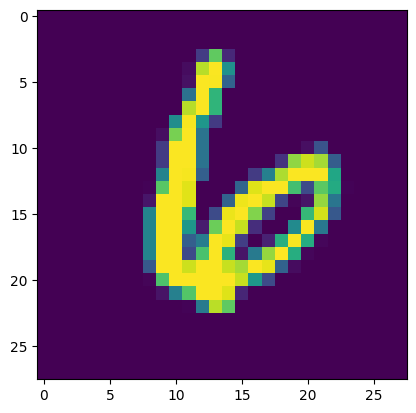

In [12]:
plt.imshow(img_orig)

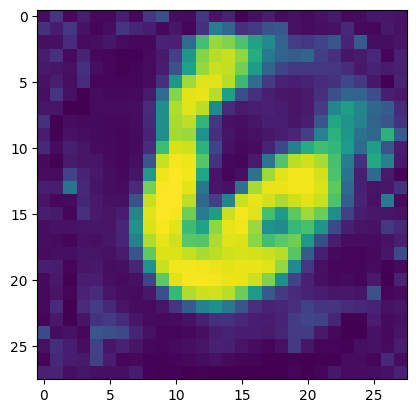

In [13]:
plt.imshow(img_rec)

In [14]:
# let's train logistic regression to classify images
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# let's split the images for classification into two sets: training and testing
X_class_train = X_classification_input[:8000]
y_class_train = y_classification[:8000]
X_class_test = X_classification_input[8000:]
y_class_test = y_classification[8000:]

# ==========================================================================

# 1. using full original features (784 pixel values)
print(X_class_train.shape, X_class_test.shape)
print(y_class_train.shape, y_class_test.shape)

class_model = LogisticRegression(C = 1)
class_model.fit(X_class_train, y_class_train)
preds = class_model.predict(X_class_test)
print(preds.shape)

acc = accuracy_score(preds, y_class_test)
print("Classification accuracy, raw pixel features: " + str(acc))


(8000, 784) (2000, 784)
(8000,) (2000,)
(2000,)
Classification accuracy, raw pixel features: 0.9225


C:\Goran\System\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# and 2. using the encoded features, obtained from each image from the autoencoder's encoder (64 values)
X_class_train = X_classification_encoded[:8000]
X_class_test = X_classification_encoded[8000:]
y_class_train = y_classification[:8000]
y_class_test = y_classification[8000:]

print(X_class_train.shape, X_class_test.shape)

class_model = LogisticRegression(C = 0.5)
class_model.fit(X_class_train, y_class_train)
preds = class_model.predict(X_class_test)
print(preds.shape)

acc = accuracy_score(preds, y_class_test)
print("Classification accuracy, from autoencoded representations: " + str(acc))


(8000, 64) (2000, 64)
(2000,)
Classification accuracy, from autoencoded representations: 0.9115


C:\Goran\System\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Convolutional Neural Networks

In this part of the tutorial we'll classify the MNIST images using the classification model based on the Convolutional Neural Network as the encoder. 

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

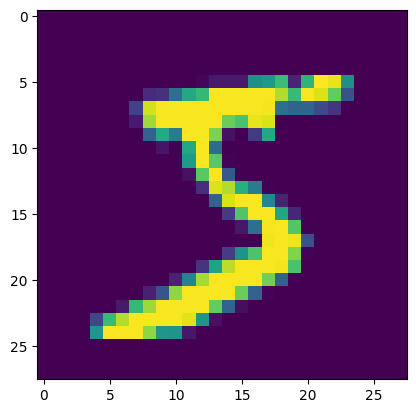

In [23]:
from keras.utils import to_categorical

# let's just load MNIST from scratch

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data so it fits the CNN model of Keras
# first dim: number of instances; second and third dim: size of the image matrix; 
# last dim: number of channels (there can possibly be different image channels, e.g., RGB, one channel for each color). Here we use only one channel (our images are greyscale)

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# normalizing the pixel values to [0.0, 1.0] interval
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# also, we need to one-hot-encode the label for each image because we will use the categorical cross-entropy loss
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train[0])
print(y_train[0])
plt.imshow(X_train[0])

Let's now define our CNN model in Keras. We do it the same way we did for Autoencoder, by pipelining explicitly each "layer" of the model. We're defining a model with 2 convolutional (and 2 pooling) layers.  

1. Image is the input to a 2-D Convolutional layer (Conv2D)
2. the output of the first Conv2D layer is input to the Max. Pooling layer
3. the output of the first pooling layer is the input into the second convolutional layer
4. the output of the second conv. layer is input into the second max. pooling layer
5. finally, we flatten (Flatten) the "reduced" image matrix, output of the second pooling layer -- these are the final features that go into score prediction for each class
6. Final Dense layer that projects final features (output of Flatten) into 10 scores (one of each class, activation="softmax" converts these scores into a probability distribution)

In [35]:
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1, ))

# first convolution layer
first_conv = Conv2D(64, kernel_size=5, activation='relu', input_shape=(28,28,1))(input_img)

# first pooling layer
first_pool = MaxPooling2D(pool_size=(2, 2))(first_conv)

# second convolution layer
second_conv = Conv2D(32, kernel_size=3, activation='relu')(first_pool)

# second pooling layer
second_pool = MaxPooling2D(pool_size=(2, 2))(second_conv)

# flattening the remaining 2D matrix into a vector
representation = Flatten()(second_pool)

cl_layer = Dense(10, activation='softmax')(representation)

# full autoencoder for training
classifier = Model(input_img, cl_layer)

# OPTIONAL
# intermediate models, for obtaining intermediate representations
conv2d_1 = Model(input_img, first_conv)
pool_1 = Model(input_img, first_pool)
conv2d_2 = Model(input_img, second_conv)
pool_2 = Model(input_img, second_pool)
reps = Model(input_img, representation)

Now that we have *defined* the model, we can actually execute its training (i.e., optimization of model's parameters) on our training data. We will use "Adam" (https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as optimization algorithm (you can think of it as a more elaborate version of gradient descent). We will minimize the cross-entropy loss (standard loss function for multi-class classification) and reported the performance in terms of accuracy as the evaluation metric. We will train for 3 epochs (number of times we let the model "see" all training instances) in batches of 32 examples (one update of model's parameters is based on the sum of prediction losses for these 32 examples).  

In [36]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
1875/1875 [==============================] - 80s 42ms/step - loss: 0.1599 - accuracy: 0.9513 - val_loss: 0.0601 - val_accuracy: 0.9816
Epoch 2/3
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0534 - accuracy: 0.9841 - val_loss: 0.0479 - val_accuracy: 0.9840
Epoch 3/3
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0389 - accuracy: 0.9876 - val_loss: 0.0394 - val_accuracy: 0.9877


We can also check what the "output" of each layer looks like (we make predictions for a single test image, X_test[i])

1/1 [==============================] - 0s 63ms/step
After first convolution: (24, 24, 64)
1/1 [==============================] - 0s 48ms/step
After first pooling: (12, 12, 64)
1/1 [==============================] - 0s 65ms/step
After second convolution: (10, 10, 32)
1/1 [==============================] - 0s 62ms/step
After second pooling: (5, 5, 32)
1/1 [==============================] - 0s 64ms/step
After flattening: (800,)
1/1 [==============================] - 0s 58ms/step
Classification result: [2.7416163e-06 2.5403806e-13 3.8084297e-10 3.3274125e-06 6.4125856e-14
 9.9999332e-01 5.0603560e-10 2.5063017e-07 2.7458094e-07 6.7529385e-08]
Real class:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


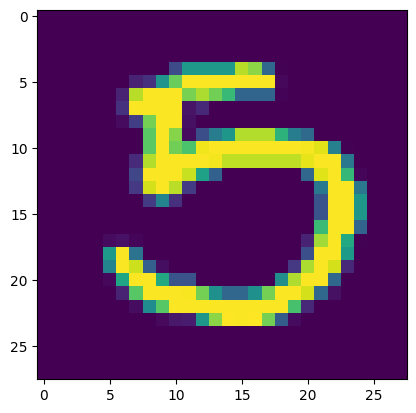

In [38]:
i = 352

preds = conv2d_1.predict(np.array([X_test[i]]))
print("After first convolution: " + str(preds[0].shape))

preds = pool_1.predict(np.array([X_test[i]]))
print("After first pooling: " + str(preds[0].shape))

preds = conv2d_2.predict(np.array([X_test[i]]))
print("After second convolution: " + str(preds[0].shape))

preds = pool_2.predict(np.array([X_test[i]]))
print("After second pooling: " + str(preds[0].shape))

preds = reps.predict(np.array([X_test[i]]))
print("After flattening: " + str(preds[0].shape))

preds = classifier.predict(np.array([X_test[i]]))
print("Classification result: " + str(preds[0]))

print("Real class:")
print(y_test[i])

plt.imshow(X_test[i])

As mentioned in the beginning, we can also define Keras models more elegantly (so we don't have to explicitly pipeline layers ourselves) with the use of the class "Sequential" -- this defines which layers are stacked and in which order.  

In [39]:
from keras.models import Sequential

#create model: Sequential model is just a linear stack of layers: 
#added layers will be executed in sequence, one after the other
model = Sequential()

#add layers to the model
model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))           
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [40]:
# with Sequential, we have defined the very same CNN model architecture as before, only in a more elegant and concise way
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Epoch 1/3
1875/1875 [==============================] - 60s 31ms/step - loss: 0.1875 - accuracy: 0.9424 - val_loss: 0.0562 - val_accuracy: 0.9813
Epoch 2/3
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0583 - accuracy: 0.9823 - val_loss: 0.0369 - val_accuracy: 0.9873
Epoch 3/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0503 - val_accuracy: 0.9835


## Recurrent neural networks

RNNs are designed for modelling sequences. In this tutorial we will see how to use the RNNs for part-of-speech tagging. 
Let's first load some POS data for training/evaluating the model. 

In [77]:
#!pip install nltk
import numpy as np
import nltk
#nltk.download('treebank')


In [78]:
tagged_sents = nltk.corpus.treebank.tagged_sents()
print(tagged_sents[0])
print(len(tagged_sents))

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
3914


In [79]:
# preprocessing, splitting tokens from tags
sentences, tag_seqs = [], []
for tag_sent in tagged_sents:
  sent, tags = zip(*tag_sent)
  sentences.append([t.lower() for t in sent])
  tag_seqs.append(list(tags))

ind = 31
print(sentences[ind])
print(tag_seqs[ind])

['``', 'but', 'you', 'have', '*-1', 'to', 'recognize', 'that', 'these', 'events', 'took', 'place', '35', 'years', 'ago', '.']
['``', 'CC', 'PRP', 'VBP', '-NONE-', 'TO', 'VB', 'IN', 'DT', 'NNS', 'VBD', 'NN', 'CD', 'NNS', 'IN', '.']


Our input texts are "words", and our labels are POS tags. NNs take numeric input, we need to convert them to IDs (build the vocabularies) first. 

In [80]:
def build_vocabulary(sequences):
  vocab = {}
  for seq in sequences:
    for item in seq:
      if item not in vocab:
        vocab[item] = len(vocab)
  return vocab

vocab_tokens = build_vocabulary(sentences)
vocab_tags = build_vocabulary(tag_seqs)

# adding a special padding token
vocab_tokens["<PAD>"] = len(vocab_tokens)
vocab_tags["<PAD>"] = len(vocab_tags)

print(len(vocab_tokens))
print(len(vocab_tags))
print(vocab_tags)

11388
47
{'NNP': 0, ',': 1, 'CD': 2, 'NNS': 3, 'JJ': 4, 'MD': 5, 'VB': 6, 'DT': 7, 'NN': 8, 'IN': 9, '.': 10, 'VBZ': 11, 'VBG': 12, 'CC': 13, 'VBD': 14, 'VBN': 15, '-NONE-': 16, 'RB': 17, 'TO': 18, 'PRP': 19, 'RBR': 20, 'WDT': 21, 'VBP': 22, 'RP': 23, 'PRP$': 24, 'JJS': 25, 'POS': 26, '``': 27, 'EX': 28, "''": 29, 'WP': 30, ':': 31, 'JJR': 32, 'WRB': 33, '$': 34, 'NNPS': 35, 'WP$': 36, '-LRB-': 37, '-RRB-': 38, 'PDT': 39, 'RBS': 40, 'FW': 41, 'UH': 42, 'SYM': 43, 'LS': 44, '#': 45, '<PAD>': 46}


In [81]:
# padding all sentences to the length of the longest 
max_len = max([len(x) for x in sentences])
print(max_len)

padded_sents = [sent + ["<PAD>"] * (max_len - len(sent)) for sent in sentences]
padded_tagseqs = [ts + ["<PAD>"] * (max_len - len(ts)) for ts in tag_seqs]

print(padded_sents[0])
print(padded_tagseqs[0])

# HINT: you can also use Keras to pad sequences
# See: from keras.preprocessing.sequence import pad_sequences

271
['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'

In [82]:
# replacing the strings (words and tags) with IDs from the vocabulary

sents_ids = [[vocab_tokens[t] for t in s] for s in padded_sents]
print(sents_ids[0])

tags_ids = [[vocab_tags[t] for t in ts] for ts in padded_tagseqs]
print(tags_ids[0])

# we additionally need to convert the labels into one-hot-encoding vectors (to be able to use categorical_crossentropy loss in the model)
tags_labels = []
for t_seq in tags_ids:
  cat_labs = []
  for tag in t_seq:
    lab_vec = np.zeros(len(vocab_tags))
    lab_vec[tag] = 1.0
    cat_labs.append(lab_vec)
  tags_labels.append(cat_labs)

tags_labels = np.array(tags_labels)
#print(tags_labels[0])
    

[0, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 11387, 

In [83]:
# Finally, let's split out data into train and test sets
ind_train = (int)(0.8 * len(sents_ids))
x_train = np.array(sents_ids[:ind_train])
y_train = np.array(tags_labels[:ind_train])
x_test = np.array(sents_ids[ind_train:])
y_test = np.array(tags_labels[ind_train:])

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

3131 3131
783 783


Now that we have loaded and prepared the data, it's time to build our model, which consists of: 

1. Embedding layer: fetches a word embedding for our words. It is possible to plug in pre-trained word embeddings. In our case, we just randomly initialize numeric vectors for our words and learn then also as parameters of the model. 

2. Recurrent layer: we will use a bidirectional RNN (Bidirectional modifier) with LSTM cell in both undirectional nets (LSTM modifier). Setting the *return_sequences* parameter to "True" makes sure LSTM outputs a sequence of representations (one for each word), not only one final state for the whole sequence.

3. Dense Layer (or fully-connected layer) is a classifier that will transform the representation and predict the POS tag (i.e., label). Since we need to apply this classifier on every word, that is, on every vector of the sequence outputed by the LSTM, we need to add the TimeDistributed modifier.


In [84]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(InputLayer(input_shape=(max_len, )))
model.add(Embedding(len(vocab_tokens), 32)) # the number specifies the dimension for word embedding vectors
model.add(Bidirectional(LSTM(64, return_sequences=True))) # the number specifies the dimension/size of the LSTM state vector
model.add(TimeDistributed(Dense(len(vocab_tags))))
model.add(Activation('softmax'))
 
model.summary()
 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 271, 32)           364416    
                                                                 
 bidirectional_2 (Bidirectio  (None, 271, 128)         49664     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 271, 47)          6063      
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 271, 47)           0         
                                                                 
Total params: 420,143
Trainable params: 420,143
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 43s 4s/step - loss: 3.6849 - accuracy: 0.7188 - val_loss: 3.3310 - val_accuracy: 0.9092
Epoch 2/20
10/10 [==============================] - 31s 3s/step - loss: 2.0713 - accuracy: 0.9039 - val_loss: 0.5572 - val_accuracy: 0.9092
Epoch 3/20
10/10 [==============================] - 41s 4s/step - loss: 0.5689 - accuracy: 0.9039 - val_loss: 0.5373 - val_accuracy: 0.9092
Epoch 4/20
10/10 [==============================] - 51s 5s/step - loss: 0.5381 - accuracy: 0.9039 - val_loss: 0.4397 - val_accuracy: 0.9092
Epoch 5/20
10/10 [==============================] - 52s 5s/step - loss: 0.4182 - accuracy: 0.9039 - val_loss: 0.3843 - val_accuracy: 0.9092
Epoch 6/20
10/10 [==============================] - 49s 5s/step - loss: 0.3898 - accuracy: 0.9039 - val_loss: 0.3527 - val_accuracy: 0.9092
Epoch 7/20
10/10 [==============================] - 57s 6s/step - loss: 0.3612 - accuracy: 0.9039 - val_loss: 0.3415 - val_accuracy: 0.9092
Epoch 8/20
10/10 [==

We have now trained the model, let's test its performance on the test portion of our sentences (not used in training)

In [98]:
# let's predict and evaluate on the test set 
type(x_test)
scores = model.evaluate(x_test, y_test)
print("Avg test loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1] * 100))

numpy.int32